In [1]:
# default_exp domains

# Domains

Once the data is loaded, it is important to visualize all of the tests in their relative contexts.
No single tests will hold all of the answers for a domain.

A useful interactive visualization system has the following properties:
 - Handles creating and arranging multiple figures
   - Handle passing raw data to transforms for normalization
   - Handle generating axes
 - Maintains a common data source for linked brushing
 - Can export selections (future)

Let's load in our large dataset and start playing with the full data to workout bugs.

In [1]:
# hide
%load_ext autoreload
%autoreload 2

# hide
import warnings
warnings.simplefilter(action='ignore')

In [2]:
# export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import yaml

from autoneuro.operators import AbstractOperation, AggregationOp
from autoneuro.calculators import TestCalculator
from autoneuro.field_mapping import *
from autoneuro.batteries import *

It is important to map fields between different label schemes. The `FieldMapper` allows this to be easily defined in a common table format.

In [3]:
SHOW_DATA = 'new' # new or old

if SHOW_DATA == 'new':
    paths = [('redcap_id', 'data/ducomout/ClinicalAndTranslati_DATA_2021-04-24_1737.csv'),
             ('cnns_id', 'data/cnns/EXPORT_DD.csv')]
    req_fields = ['cnns_bvmt_t']
else:
    paths = [('oldneuro_id', 'data/neuro_data.xlsx')]
    req_fields = ['bvmt_trial1']


mapper = FieldMapper.from_file('data/field_mappings_merged.xlsx', post_convert=[fix_study_ids, fix_dates])
map_neuro = mapper.multi_merge('internal_field', paths, index_keys = ['study_id', 'date_of_visit']).dropna(subset = req_fields)
map_neuro.head()

,,abdominal_girth,age,age_first_drivers_license,age_first_used_drug,agenp,aids_defining_indicat2_2dd,aids_defining_indicators,also_driving_assessment,amitriptyline_end_date,amitriptyline_start_date,...,year_diagnosed_tuberculosi,year_diagnosed_uterine_can,year_diagnosed_with_asthma,year_diagnosed_with_copd,year_diagnosed_with_diabet,year_diagnosed_with_elevat,year_diagnosed_with_hypert,years_seropositive,you_get_angry_at_the_behav,you_intend_to_drive_to_des
study_id,date_of_visit,,,,,,,,,,,,,,,,,,,,,
2,2021-03-11,37.5,70.0,30,22yo,70.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,0.0
5,2020-11-19,51.5,61.0,None,None,61.0,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,1964.0,2008.0,2010.0,2014.0,NaN,36 years,NaN,NaN
13,2021-02-25,37.0,75.0,18yo,None,75.0,NaN,NaN,1.0,NaN,NaN,...,1996.0,NaN,NaN,2003.0,2019.0,2007.0,2009.0,23 years,0.0,0.0
25,2021-03-16,47.5,63.0,62yo,16yo,63.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,2020.0,2019.0,2009.0,2000.0,21 Years,2.0,1.0
38,2021-01-13,50.0,51.0,30yo,13yo,51.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,1973.0,NaN,NaN,2007.0,2012.0,25 years,0.0,0.0


This system will be built by visualizations which match to specific neurological batteries.
In the abstract, a battery defines a set of measurement fields and how they relate.
Then it can generate visualization modules both the raw and normalized fields as needed.
A collection of these `Battery` objects will be combined into a `Domain`.

In [4]:
# export
# hide
from bokeh.transform import factor_cmap, factor_mark
from bokeh.models import BooleanFilter, CDSView, BoxAnnotation, Band, IndexFilter, BooleanFilter, FactorRange
from bokeh.models import Legend, LegendItem

from bokeh.models import ColumnDataSource, HoverTool, Range1d
from bokeh.plotting import figure
from bokeh.layouts import gridplot, layout
from bokeh.io import show

Those tests will likely become more complicated and less "abstract" as we go.
But they're enough to represent each test and contain the information we need.

Now that we have a way of representing tests, lets merge them into domains and start visualizing.

In the abstract a domain collection should:
  - Hold the test calculator and hold a list a "defining_tests".
  - Manage the processing of the data with the calculator.
  - Hold Bokeh data like the `ColumnDataSource`, shared ranges, etc.
  - Combine the "defining_test" using an aggregation method.

In [5]:
# export
# hide

def zscore2deficit(zscore):

    # nan
    if (zscore != zscore) or (zscore is None): 
        return np.nan
    tscore = (zscore*10)+50
    if tscore >= 40:
        return 0
    elif tscore >= 35:
        return 1
    elif tscore >= 30:
        return 2
    elif tscore >= 25:
        return 3
    elif tscore >= 20:
        return 4

    return 5
    
    
class CNNSConversionOp(AbstractOperation):
    
    def __init__(self, in_field, out_field = None):
        
        if out_field is None:
            out_field = in_field.rsplit('_', 1)[0]
            out_field += '_z'
        
        self.fields = [in_field]
        self.result_fields = [out_field]
        
        self.internal_field = out_field
        self.calculation = f'Z-score scaling of CNNS T-scale result of {in_field}'
        
    @staticmethod
    def multi_cnns(*args):
        
        return [CNNSConversionOp(field) for field in args]
        
        
        
    def explain(self, row):
        zscale = self.process_single(row)
        data = self.to_series(row)
        tscore = data[self.fields[0]]
        
        message = [f'CNNS Scaling: Scaling t-score {self.fields[0]} = {tscore}',
                   f'CNNS Scaling: to z-scale {self.result_fields[0]} = {zscale}'
                  ]
        
        return '\n'.join(message)

    def process_single(self, row):
        data = self.to_series(row)
        zscale = (data[self.fields[0]]-50)/10
        return zscale
    
    
    
class DomainScoreOp(AggregationOp):
    
    def __init__(self, out_field, fields, aggregation='mean'):
        """

        Parameters
        ----------
        out_field : str
        aggregation : str
        fields : list[str]
        """

        self.fields = fields
        self.aggregation = aggregation
        self.result_fields = [out_field]
        
        self.internal_field = out_field
        self.calculation = f'{aggregation} of {fields}'
    
    
class DeficitScoreOp(AbstractOperation):
    
    def __init__(self, in_field, out_field):
        
        self.fields = [in_field]
        self.result_fields = [out_field]
        
        self.internal_field = out_field
        self.calculation = f'Defict score scaling of {in_field}'
        
    def explain(self, row):
        deficit = self.process_single(row)
        zscore = row[self.fields[0]]
        tscore = (zscore*10)+50
        message = [f'Deficit Scaling: {self.fields[0]} = {row[self.fields[0]]} in z-scale units',
                   f'Deficit Scaling: Converted to a T-score of {tscore}',
                   f'Deficit Scaling: Which is a deficit score of {deficit}',
                  ]
        
        return '\n'.join(message)

    def process_single(self, row):
        data = self.to_series(row)
        deficit = zscore2deficit(data[self.fields[0]])
        return deficit
    
    

    
class ABDomainBattery(AbstractBattery):
    
    prefix = ''
    domain_cols = []
    prefix_ops = []
    
    
    @property
    def deficit_score_field(self):
        return self.prefix + '_deficit'
    
    @property
    def z_score_field(self):
        return self.prefix + '_z'
    
    
    @classmethod
    def from_defaults(cls, root_data = '/data'):
        
        dom_score = DomainScoreOp(cls.prefix + '_z', 
                                  cls.domain_cols) # 'senas_wordlist_total'
        deficit_score = DeficitScoreOp(cls.prefix + '_z', 
                                       cls.prefix + '_deficit')
        calc = TestCalculator(cls.prefix, cls.prefix_ops + [dom_score, deficit_score])
        
        return cls(calc, [cls.prefix + '_z'])
    
    

    

In [33]:
# export
# hide

import os
from itertools import chain
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import QuantileTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import quantile_transform

def quantile_df(df, **kwargs):
    
    normed = quantile_transform(df, **kwargs)
    return pd.DataFrame(normed, index = df.index, columns = df.columns)



class AbstractDomain(object):

    source = None
    data = None
    ranges = {}
    _weights = 1
    tools = "pan,wheel_zoom,box_zoom,reset,box_select,lasso_select"

    def __init__(self, batteries, deficit_score_name = None, final_fields = None):
        """
        Parameters
        ----------
        batteries : list[Battery]
        agg_method : str
        """
        
        self.calculator = TestCalculator(self.name, [])
        for bat in batteries:
            self.calculator = self.calculator + bat.calculator
        self.batteries = batteries
        if deficit_score_name is None:
            try:
                deficit_score_name = self.batteries[-1].deficit_score_field
            except AttributeError:
                pass
        self.deficit_score_name = deficit_score_name
        self.domain_score_field = batteries[-1].scaled_fields[0]
        self._final_fields = batteries[-1].domain_cols if final_fields is None else final_fields 
        
    @property
    def name(self):
        return self.__class__.__name__
        
        
    @property
    def final_fields(self):
        if self._final_fields is None:
            fields = []
            for battery in self.batteries:
                fields += battery.scaled_fields
            return fields
        else:
            return self._final_fields
    
    @property
    def required_fields(self):
        fields = []
        for battery in self.batteries:
            fields += battery.required_fields
        return sorted(set(fields))
    
    
    def _load_data(self):
        pass
    
    def group_data(self, data):
        
        ages = pd.cut(data['age'], [18, 50, 100])
        return ages
    
    def __call__(self, df):
        
        res = self.calculator.process_dataframe(df)
        res = res.loc[:, ~res.columns.duplicated()]
        return res
    
    
    def scale_data(self, data):
        
        n_quantiles = 50
        scaled_data = []
        
        for battery in self.batteries:
            dt = battery.scaled_data(data)
            if battery.z_scaled:
                scaled_data.append(dt.copy())
            else:
                groups = self.group_data(data)
                out_data = dt.groupby(groups).apply(lambda x: quantile_df(x, output_distribution = 'normal', n_quantiles=n_quantiles))
                scaled_data.append(out_data.copy())
                
        return pd.concat(scaled_data, axis=1)
    

    def load_data(self, data):
        
        scaled_data = self(data)
        self.data = scaled_data #pd.concat([data, scaled_data], axis=1)
        if 'age' not in self.data:
            self.data['age'] = data['age']
        self._load_data()
        #self.aggregate_scores()
        self.source = ColumnDataSource(self.data)
        
        

    def build_scatter_fig(self, x = None, y = None,
                          fig = None, scatter_kwargs = None):

        x_range = self.ranges.get(x, Range1d(-10, 10))
        y_range = self.ranges.get(y, Range1d(-10, 10))
        default = {'x_range': x_range, 'y_range': y_range, 'tools': self.tools}
        if fig is None:
            fig = figure(**default)
        elif type(fig) == dict:
            fig = figure(**fig, **default)

        scatter_kwargs = {} if scatter_kwargs is None else scatter_kwargs
        fig.scatter(x = x, y = y, source = self.source,
                    **scatter_kwargs)
        fig.xaxis.axis_label = x
        fig.yaxis.axis_label = y

        self.ranges[x] = fig.x_range
        self.ranges[y] = fig.y_range

        return fig

    def aggregate_scores(self):

        ndata = self.data[self.final_fields].dropna(axis=1, how = 'all')
        if len(ndata.columns) >= 2:
            filled_data = KNNImputer().fit_transform(ndata)
            svd = TruncatedSVD(n_components=1, random_state=12)
            svd.fit(filled_data)
            weights = np.abs(svd.components_[0, :]) # Deal with sign
            weights = weights / np.sum(weights) # Deal with scale
            self._weights = pd.Series(weights, index = ndata.columns)
        else:
            self._weights = pd.Series([1]*len(ndata.columns), index = ndata.columns)
        
        if self.agg_method == 'SVD':
            def linker(row, weights):
                mask = row.notnull()
                if mask.any():
                    return np.average(row[mask], weights = weights[mask])
                return np.nan
    
            res = ndata.apply(lambda row: linker(row, weights), axis=1)
        
        elif self.agg_method == 'mean':
            res = ndata.clip(lower=-3, upper=3).mean(axis=1)
        else:
            raise ValueError('Did not understand aggmethod: ' + self.agg_method)

        self.data['aggregated_score'] = res
        self.data['deficit_score'] = self.data['aggregated_score'].map(zscore2defict)

    def build_aggscore_figures(self, fig = None, scatter_kwargs = None):

        if 'aggregated_score' not in self.data.columns:
            self.aggregate_scores()

        figs = []
        for col in self.data.columns:
            figs.append(self.build_scatter_fig(x = col, y = 'aggregated_score',
                                               scatter_kwargs=scatter_kwargs,
                                               fig=fig))

        return figs
    
    @property
    def corr_mat(self):
        plt_data = self.data[self.final_fields+['age']]
        return plt_data.loc[:, ~plt_data.columns.duplicated()].corr()
    
    def build_pairplot(self, extra_cols = ['age'], pairplot_kwargs = {}):
        plt_data = self.data[self.final_fields+extra_cols]
        return sbn.pairplot(plt_data.loc[:, ~plt_data.columns.duplicated()], **pairplot_kwargs)
    
    def build_deficit_plot(self, field = None, ax = None):
        field = self.deficit_score_name if field is None else field
        sbn.countplot(data = self.data,
                      x = field,
                      ax = ax)    
        return ax
    
    def summarize_domain(self, data):
        self.load_data(data)
        
        print(self.name)
        print('Batteries: ' + ', '.join(bat.__class__.__name__ for bat in self.batteries))
        print('Composed of: ' + ', '.join(self.final_fields))
        
        print('Example calculation:')
        item = data.sample(1)
        print(self.calculator.explain(item.iloc[0]))
        
        
        self.build_pairplot()
        fig, ax = plt.subplots(1,1)
        self.build_deficit_plot(ax=ax)
        
        return self
        


In [14]:
# export
# hide
from sklearn.preprocessing import quantile_transform

def quantile_df(df, **kwargs):
    
    normed = quantile_transform(df, **kwargs)
    return pd.DataFrame(normed, index = df.index, columns = df.columns)


def quantile_transform_placeholders(data, suffix = '_plc', n_quantiles = 50, age_norm = True):
    
    cols = [col for col in data.columns if col.endswith(suffix)]
    
    if age_norm:
        ages = pd.cut(data['age'], [18, 50, 100])
        out_data = data.groupby(ages)[cols].apply(lambda x: quantile_df(x, output_distribution = 'normal', n_quantiles=n_quantiles))
    else:
        out_data = quantile_df(data[cols], output_distribution = 'normal', n_quantiles=n_quantiles)
    
    return pd.DataFrame(out_data, columns = cols, index = data.index)


#quantile_transform_placeholders(ex_fun_domain.data, suffix='unnorm').plot(kind = 'hist')
    
    

# Verbal Memory Domain

In [15]:
from autoneuro.batteries import BVMTBattery, HVLTBattery, SENASWordlistBattery, AbstractBattery

class VerbalMemoryBattery(ABDomainBattery):
    
    section = 'VerbalMemory Domain'
    prefix = 'verbalmemory_domain'
    
    domain_cols = ['hvlt_recognition_heaton_z', 
                   'hvlt_delay_heaton_z', 
                   'hvlt_total_heaton_z']
    
    
class NewVerbalMemoryBattery(VerbalMemoryBattery): 
    prefix_ops = CNNSConversionOp.multi_cnns('cnns_hvlt_t',
                                             'cnns_hvlt4_t',
                                             'cnns_hdiscrim_t',
                                             'cnns_hretain_t')
    domain_cols = ['cnns_hvlt_z',
                   'cnns_hvlt4_z',
                   'cnns_hdiscrim_z']
    
    
class VerbalMemoryDomain(AbstractDomain):

    @staticmethod
    def from_defaults(root_data = 'data/', method = 'new'):
        
        batteries = [HVLTBattery.from_defaults()]
        if method == 'new':
            batteries.append(NewVerbalMemoryBattery.from_defaults())
        else:
            batteries.append(VerbalMemoryBattery.from_defaults())


        return VerbalMemoryDomain(batteries)    
    



VerbalMemoryDomain
Batteries: HVLTBattery, NewVerbalMemoryBattery
Composed of: cnns_hvlt_z, cnns_hvlt4_z, cnns_hdiscrim_z
Example calculation:
Input: 
 age:56.0
 cnns_hdiscrim_t:22.0
 cnns_hretain_t:39.0
 cnns_hvlt4_t:34.0
 cnns_hvlt_t:26.0
 hvlt1intr:1.0
 hvlt1pers:0.0
 hvlt2pers:2.0
 hvlt_delay:3.0
 hvlt_false_pos:4.0
 hvlt_hits:7.0
 hvlt_trial1:3.0
 hvlt_trial2:5.0
 hvlt_trial3:4.0
Calculating: ['hvlt_total']
Used Equation: hvlt_trial1+hvlt_trial2+hvlt_trial3 = 12.0 = hvlt_total 

Calculating: ['hvlt_recognition']
Used Equation: hvlt_hits+hvlt_false_pos = 11.0 = hvlt_recognition 

Calculating: ['hvlt_total_heaton_z']
Matched: age >= 54
Expected 27.86+/-3.95 but observed 12.0
Scaled to: z=-4.015189873417722 

Calculating: ['hvlt_delay_heaton_z']
Matched: age >= 54
Expected 10.06+/-1.73 but observed 3.0
Scaled to: z=-4.08092485549133 

Calculating: ['hvlt_recognition_heaton_z']
Matched: age >= 54
Expected 10.79+/-1.61 but observed 11.0
Scaled to: z=0.13043478260869618 

Calculating: [

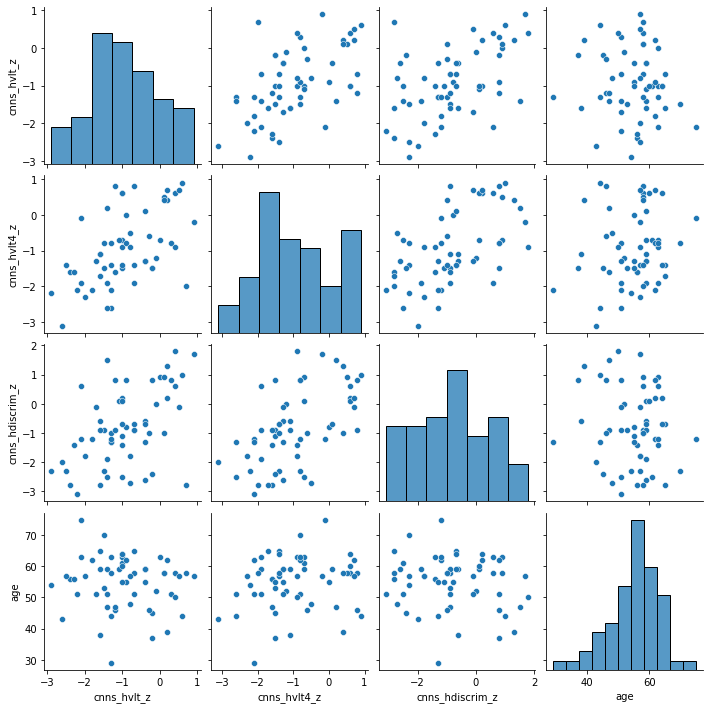

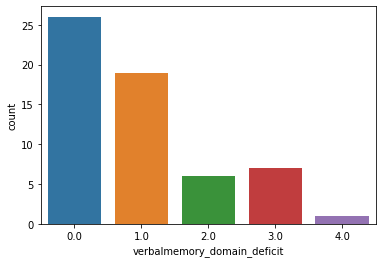

In [16]:
verb_mem_domain = VerbalMemoryDomain.from_defaults(method = SHOW_DATA)
verb_mem_domain.summarize_domain(map_neuro)

# Visuospatial Memory

Measured by the BVMT score.

In [18]:
#export

from autoneuro.batteries import BVMTBattery, HVLTBattery, SENASWordlistBattery, AbstractBattery

class VisuospatialMemoryBattery(ABDomainBattery):
    
    section = 'VisuospatialMemory Domain'
    prefix = 'vismemory_domain'
    domain_cols = ['bvmt_immediate_heaton',
                   'hvlt_recognition_heaton', 'hvlt_delay_heaton', 
                   'hvlt_total_heaton']   
    
class NewVisuospatialMemoryBattery(VisuospatialMemoryBattery):
    

    prefix_ops = CNNSConversionOp.multi_cnns('cnns_bvmt_t',
                                             'cnns_bvmt4_t',
                                             'cnns_bdiscrim_t',
                                             'cnns_bretain_t')
    domain_cols = ['cnns_bvmt_z', 
                   'cnns_bvmt4_z',
                   'cnns_bdiscrim_z',
                  ] 


class VisuospatialMemoryDomain(AbstractDomain):

    @staticmethod
    def from_defaults(root_data = 'data/', method = 'new'):
        
        batteries = [BVMTBattery.from_defaults()]
        if method == 'new':
            batteries.append(NewVisuospatialMemoryBattery.from_defaults())
        else:
            batteries.append(VisuospatialMemoryBattery.from_defaults())


        return VisuospatialMemoryDomain(batteries)

VisuospatialMemoryDomain
Batteries: BVMTBattery, NewVisuospatialMemoryBattery
Composed of: cnns_bvmt_z, cnns_bvmt4_z, cnns_bdiscrim_z
Example calculation:
Input: 
 age:54.0
 bvmt_delay:2.0
 bvmt_false_pos:1.0
 bvmt_hits:5.0
 bvmt_trial1:0.0
 bvmt_trial2:4.0
 bvmt_trial3:3.0
 cnns_bdiscrim_t:29.0
 cnns_bretain_t:32.0
 cnns_bvmt4_t:24.0
 cnns_bvmt_t:31.0
Calculating: ['bvmt_immediate']
Used Equation: bvmt_trial1+bvmt_trial2+bvmt_trial3 = 7.0 = bvmt_immediate 

Calculating: ['bvmt_retention_denom']
Aggregation: max [bvmt_trial2, bvmt_trial3]  = 4.0 

Calculating: ['bvmt_learning']
Used Equation: bvmt_retention_denom - bvmt_trial1 = 4.0 = bvmt_learning 

Calculating: ['bvmt_retention']
Used Equation: 100*(bvmt_delay/bvmt_retention_denom) = 50.0 = bvmt_retention 

Calculating: ['bvmt_retention']
Clipped bvmt_retention to [0, 100] 

Calculating: ['bvmt_recognition']
Used Equation: bvmt_hits-bvmt_false_pos = 4.0 = bvmt_recognition 

Calculating: ['bvmt_immediate_heaton_z']
Matched: (54 <= age

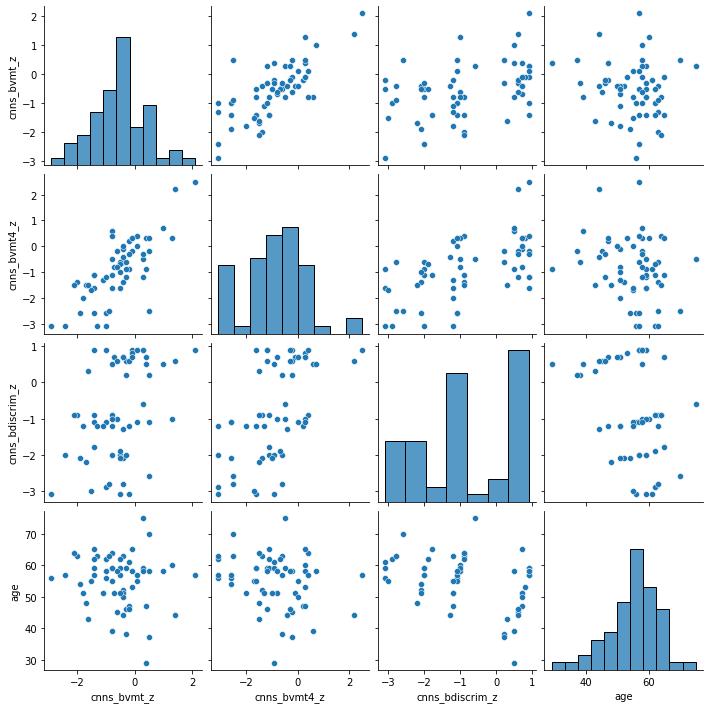

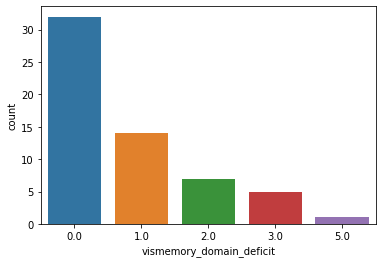

In [19]:
vis_mem_domain = VisuospatialMemoryDomain.from_defaults(method = SHOW_DATA)
vis_mem_domain.summarize_domain(map_neuro)

# Processing Speed

In [21]:
#export

from autoneuro.batteries import GroovedPegBoardBattery, TrailABattery, \
StroopBattery, WAIS4DigitSymbolBattery

class ProcessingSpeedBattery(ABDomainBattery):
    
    section = 'ProcessingSpeed Domain'
    prefix = 'processing_domain'
    domain_cols = ['traila_heaton_z',
                   'stroopword_norman_z', 
                   'stroopcolor_norman_z']

class ProcessingSpeedDomain(AbstractDomain):
    
    @staticmethod
    def from_defaults(root_data = 'data/', method = 'new'):
        
        batteries = [TrailABattery.from_defaults(),
                     
                     StroopBattery.from_defaults(final_cols = ['stroopword_norman_z', 'stroopcolor_norman_z']),
                     ProcessingSpeedBattery.from_defaults()
                    ]

        return ProcessingSpeedDomain(batteries)

ProcessingSpeedDomain
Batteries: TrailABattery, StroopBattery, ProcessingSpeedBattery
Composed of: traila_heaton_z, stroopword_norman_z, stroopcolor_norman_z
Example calculation:
Input: 
 age:52.0
 education:11.0
 race:2.0
 sex:1.0
 stroopcolor:68.0
 stroopcolorword:14.0
 stroopword:91.0
 traila:43.0
Calculating: ['heaton_gender']
sex:1.0 -> heaton_gender:1 

Calculating: ['heaton_race']
race:2.0 -> heaton_race:1 

Calculating: ['traila_scaled']
traila matched 39.0, scaled to 7.0 

Calculating: ['traila_heaton_z']
Matched: (heaton_race == 1) & ((age >= 50) & ((9 < education) & (education <= 12)) & (heaton_gender == 1))
Mapped to: 40.0
Scaled to: z=-1.0 

Calculating: ['norman_gender']
sex:1.0 -> norman_gender:0 

Calculating: ['norman_race']
race:2.0 -> norman_race:1 

Calculating: ['stroopcolor_scaled']
stroopcolor matched 66, scaled to 8 

Calculating: ['stroopcolorword_scaled']
stroopcolorword matched 0, scaled to 3 

Calculating: ['stroopword_scaled']
stroopword matched 89, scaled 

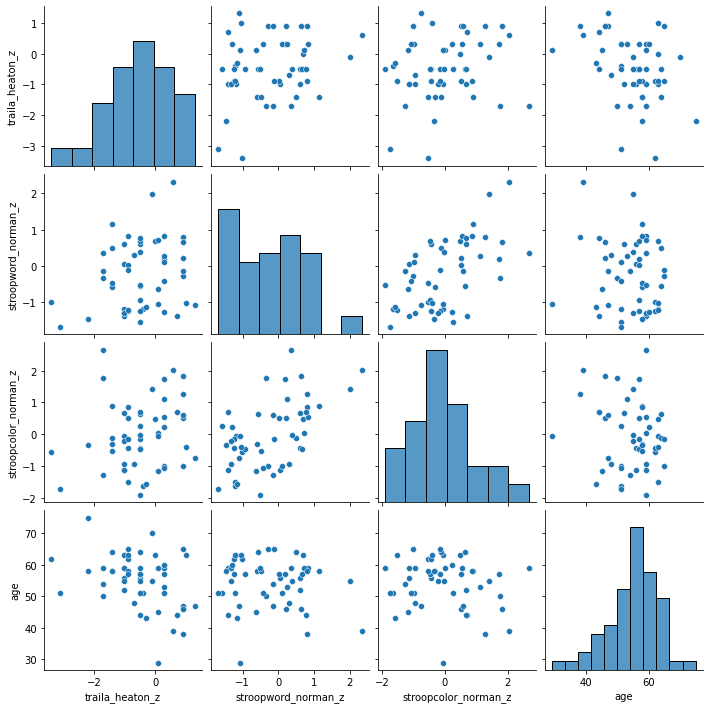

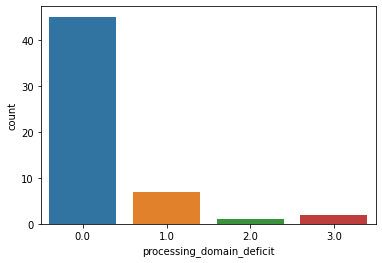

In [22]:
pro_domain = ProcessingSpeedDomain.from_defaults(method = SHOW_DATA)
pro_domain.summarize_domain(map_neuro)

# Motor Domain

In [23]:
#export

from autoneuro.batteries import GroovedPegBoardBattery, TrailABattery, \
StroopBattery, WAIS4DigitSymbolBattery

class MotorBattery(ABDomainBattery):
    
    section = 'Motor Domain'
    prefix = 'motor_domain'
    domain_cols = ['groovedpegdom_heaton_z', 'groovedpegnondom_heaton_z']

    
class NewMotorBattery(MotorBattery):
    
    prefix_ops = CNNSConversionOp.multi_cnns('cnns_gpdom1_t',
                                             'cnns_gpndom1_t',
                                             'cnns_gp_t1_mean_t')
    domain_cols = ['cnns_gpdom1_z',
                   'cnns_gpndom1_z']   
    
    

class MotorDomain(AbstractDomain):
    
    @staticmethod
    def from_defaults(root_data = 'data/', method = 'new'):
        
        batteries = [GroovedPegBoardBattery.from_defaults()]
        
        if method == 'new':
            batteries.append(NewMotorBattery.from_defaults())
        else:
            batteries.append(MotorBattery.from_defaults())


        return MotorDomain(batteries)

MotorDomain
Batteries: GroovedPegBoardBattery, NewMotorBattery
Composed of: cnns_gpdom1_z, cnns_gpndom1_z
Example calculation:
Input: 
 age:46.0
 cnns_gp_t1_mean_t:63.0
 cnns_gpdom1_t:66.0
 cnns_gpndom1_t:63.0
 education:12.0
 groovedpegdom:58.0
 groovedpegnondom:67.0
 race:2.0
 sex:1.0
Calculating: ['heaton_gender']
sex:1.0 -> heaton_gender:1 

Calculating: ['heaton_race']
race:2.0 -> heaton_race:1 

Calculating: ['groovedpegboth']
Used Equation: (groovedpegdom+groovedpegnondom)/2 = 62.5 = groovedpegboth 

Calculating: ['groovedpegdom_scaled']
groovedpegdom matched 57.0, scaled to 12.0 

Calculating: ['groovedpegnondom_scaled']
groovedpegnondom matched 65.0, scaled to 11.0 

Calculating: ['groovedpegdom_heaton_z']
Matched: (heaton_race == 1) & (((45 <= age) & (age < 50)) & ((9 < education) & (education <= 12)) & (heaton_gender == 1))
Mapped to: 65
Scaled to: z=1.5 

Calculating: ['groovedpegnondom_heaton_z']
Matched: (heaton_race == 1) & (((45 <= age) & (age < 50)) & ((9 < education) 

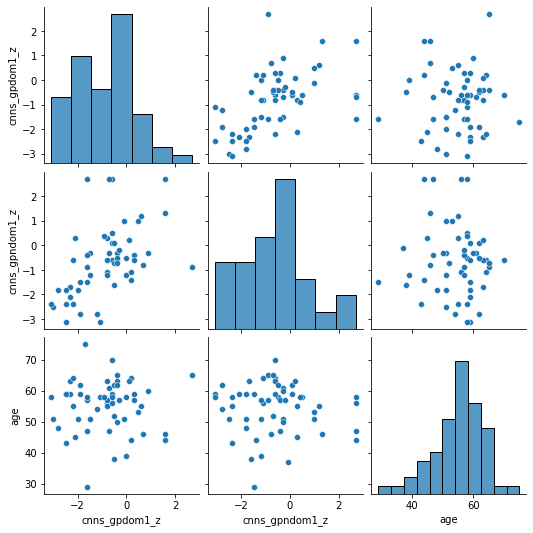

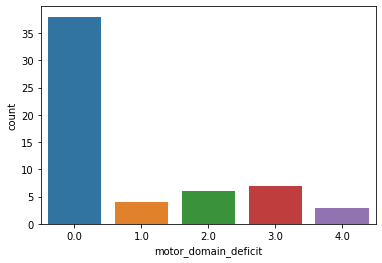

In [24]:
motor_domain = MotorDomain.from_defaults(method = SHOW_DATA)
motor_domain.summarize_domain(map_neuro)

# Executive Function

In [25]:
#export

from autoneuro.batteries import TrailBBattery, mWCSTBattery


class ExecutiveFunctionBattery(ABDomainBattery):
    
    section = 'ExecutiveFunction Domain'
    prefix = 'exec_domain'
    domain_cols = ['trailb_heaton_z', 
                   'stroopcolorword_norman_z',
                  ]
    
    
class NewExecutiveFunctionBattery(ExecutiveFunctionBattery):
    
    prefix_ops = CNNSConversionOp.multi_cnns('cnns_trlsb_t',
                                             'cnns_wcscat_t', 
                                             'cnns_wcsper_t',
                                             'cnns_wcserr_t')
    domain_cols = ['trailb_heaton_z',
                   'cnns_wcserr_z',
                   'stroopcolorword_norman_z'] 
    


class ExecutiveFunctionDomain(AbstractDomain):

    @staticmethod
    def from_defaults(root_data = 'data/', method = 'new'):
        
        batteries = [TrailBBattery.from_defaults(),
                     StroopBattery.from_defaults(final_cols = ['stroopcolorword_norman']),
                     mWCSTBattery.from_defaults(),
                    ]
        
        if method == 'new':
            batteries.append(NewExecutiveFunctionBattery.from_defaults())
        else:
            batteries.append(ExecutiveFunctionBattery.from_defaults())

        return ExecutiveFunctionDomain(batteries)

ExecutiveFunctionDomain
Batteries: TrailBBattery, StroopBattery, mWCSTBattery, NewExecutiveFunctionBattery
Composed of: trailb_heaton_z, cnns_wcserr_z, stroopcolorword_norman_z
Example calculation:
Input: 
 age:62.0
 cnns_trlsb_t:56.0
 cnns_wcscat_t:nan
 cnns_wcserr_t:nan
 cnns_wcsper_t:nan
 education:14.0
 mwcstcat:nan
 mwcsterrors:nan
 mwcstpersev:nan
 race:2.0
 sex:1.0
 stroopcolor:55.0
 stroopcolorword:20.0
 stroopword:66.0
 trailb:83.0
Calculating: ['heaton_gender']
sex:1.0 -> heaton_gender:1 

Calculating: ['heaton_race']
race:2.0 -> heaton_race:1 

Calculating: ['trailb_scaled']
trailb matched 75, scaled to 9 

Calculating: ['trailb_heaton_z']
Matched: (heaton_race == 1) & ((age >= 50) & ((13 < education) & (education <= 16)) & (heaton_gender == 1))
Mapped to: 44.0
Scaled to: z=-0.6 

Calculating: ['norman_gender']
sex:1.0 -> norman_gender:0 

Calculating: ['norman_race']
race:2.0 -> norman_race:1 

Calculating: ['stroopcolor_scaled']
stroopcolor matched 49, scaled to 5 

Calcul

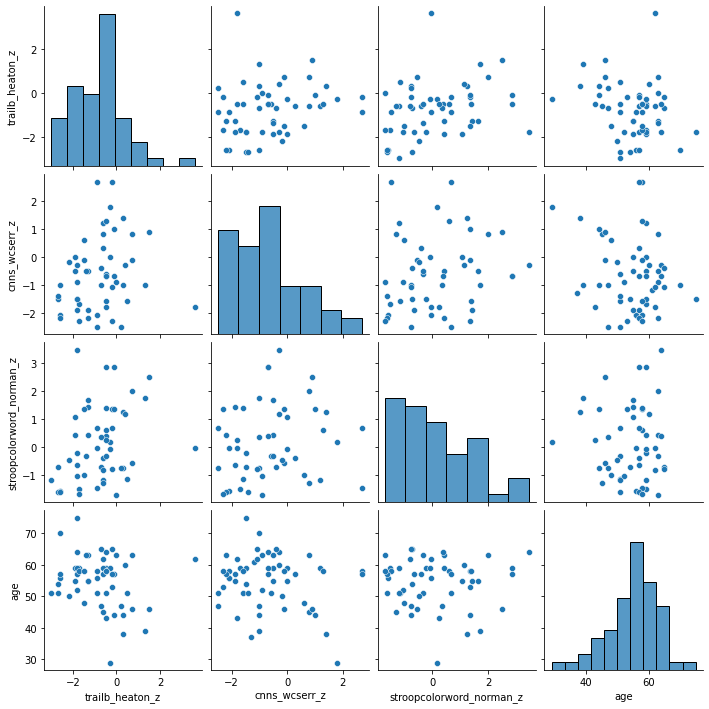

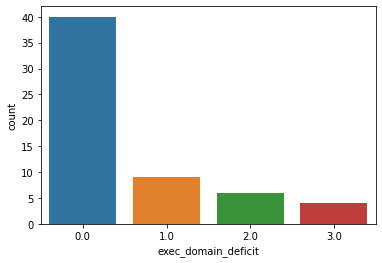

In [26]:
ex_fun_domain = ExecutiveFunctionDomain.from_defaults(method = SHOW_DATA)
ex_fun_domain.summarize_domain(map_neuro)

# Attention

In [27]:
# export

class AttentionBattery(ABDomainBattery):
    
    section = 'Attention Domain'
    prefix = 'attention_domain'
    
    domain_cols = ['digitsforward_wais4_z',
                   'digitsbackward_wais4_z',
                   'digitssequencing_wais4_z']


class AttentionDomain(AbstractDomain):
    
    @staticmethod
    def from_defaults(root_data = 'data/', method = 'new'):
        batteries = [WAIS4DigitSymbolBattery.from_defaults(),
                     AttentionBattery.from_defaults()
                    ]


        return AttentionDomain(batteries)
    

AttentionDomain
Batteries: WAIS4DigitSymbolBattery, AttentionBattery
Composed of: digitsforward_wais4_z, digitsbackward_wais4_z, digitssequencing_wais4_z
Example calculation:
Input: 
 age:75.0
 digitsbackward:6.0
 digitsforward:11.0
 digitssequencing:5.0
Calculating: ['digitspan']
Used Equation: digitsforward+digitsbackward+digitssequencing = 22.0 = digitspan 

Calculating: ['digitspan_plc']
Used Equation: digitspan = 22.0 = digitspan_plc 

Calculating: ['digitsforward_wais4_z']
Matched: (75 <= age) & (age < 80)
Mapped to: 12.0
Scaled to: z=0.6666666666666666 

Calculating: ['digitsbackward_wais4_z']
Matched: (75 <= age) & (age < 80)
Mapped to: 8.0
Scaled to: z=-0.6666666666666666 

Calculating: ['digitssequencing_wais4_z']
Matched: (75 <= age) & (age < 80)
Mapped to: 8.0
Scaled to: z=-0.6666666666666666 

Calculating: ['attention_domain_z']
Aggregation: mean [digitsforward_wais4_z, digitsbackward_wais4_z, digitssequencing_wais4_z]  = -0.2222222222222222 

Calculating: ['attention_doma

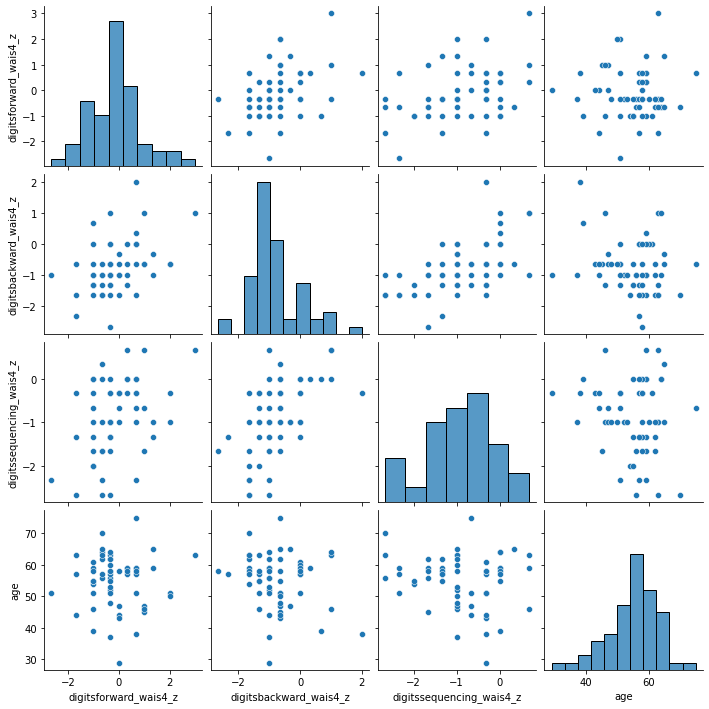

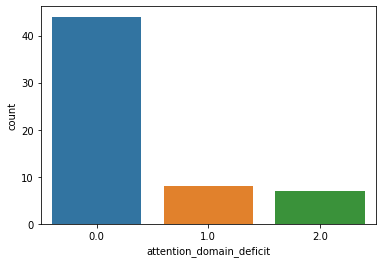

In [28]:
attn_domain = AttentionDomain.from_defaults()
attn_domain.summarize_domain(map_neuro)

## Language

In [29]:
# export

from autoneuro.batteries import CategoryFluencyAnimalsBattery, LetterFluencyBattery


class LanguageBattery(ABDomainBattery):
    
    section = 'Language Domain'
    prefix = 'language_domain'
    domain_cols = ['letterfluencyfas_total_heaton_z', 
                   'categoryfluency_total_heaton_z'
                  ]

class NewLanguageBattery(LanguageBattery):
    
    prefix_ops = CNNSConversionOp.multi_cnns('cnns_swords_t',
                                             'cnns_anwords_t',
                                             'cnns_bnt30_t')
    domain_cols = ['letterfluencyfas_total_heaton_z', 
                   'categoryfluency_total_heaton_z',
                   'cnns_bnt30_z'] 
        

class LanguageDomain(AbstractDomain):
    

    @staticmethod
    def from_defaults(root_data = 'data/', method = 'new'):
        
        batteries = [LetterFluencyBattery.from_defaults(),
                     CategoryFluencyAnimalsBattery.from_defaults(),
                     BNT30Battery.from_defaults()]
        
        if method == 'new':
            batteries.append(NewLanguageBattery.from_defaults())
        else:
            batteries.append(LanguageBattery.from_defaults())


        return LanguageDomain(batteries)

LanguageDomain
Batteries: LetterFluencyBattery, CategoryFluencyAnimalsBattery, BNT30Battery, NewLanguageBattery
Composed of: letterfluencyfas_total_heaton_z, categoryfluency_total_heaton_z, cnns_bnt30_z
Example calculation:
Input: 
 age:59.0
 bnt30:23.0
 categoryfluency_q1:8.0
 categoryfluency_q2:1.0
 categoryfluency_q3:2.0
 categoryfluency_q4:1.0
 cnns_anwords_t:38.0
 cnns_bnt30_t:41.0
 cnns_swords_t:25.0
 education:11.0
 letterfluencya_intr:0.0
 letterfluencya_pers:1.0
 letterfluencya_q1:3.0
 letterfluencya_q2:0.0
 letterfluencya_q3:0.0
 letterfluencya_q4:1.0
 letterfluencyf_intr:0.0
 letterfluencyf_pers:1.0
 letterfluencyf_q1:3.0
 letterfluencyf_q2:1.0
 letterfluencyf_q3:2.0
 letterfluencyf_q4:0.0
 letterfluencys_intr:1.0
 letterfluencys_pers:0.0
 letterfluencys_q1:1.0
 letterfluencys_q2:0.0
 letterfluencys_q3:0.0
 letterfluencys_q4:3.0
 race:2.0
 sex:1.0
Calculating: ['letterfluencyf_total']
Used Equation: letterfluencyf_q1+letterfluencyf_q2+letterfluencyf_q3+letterfluencyf_q4 = 6.

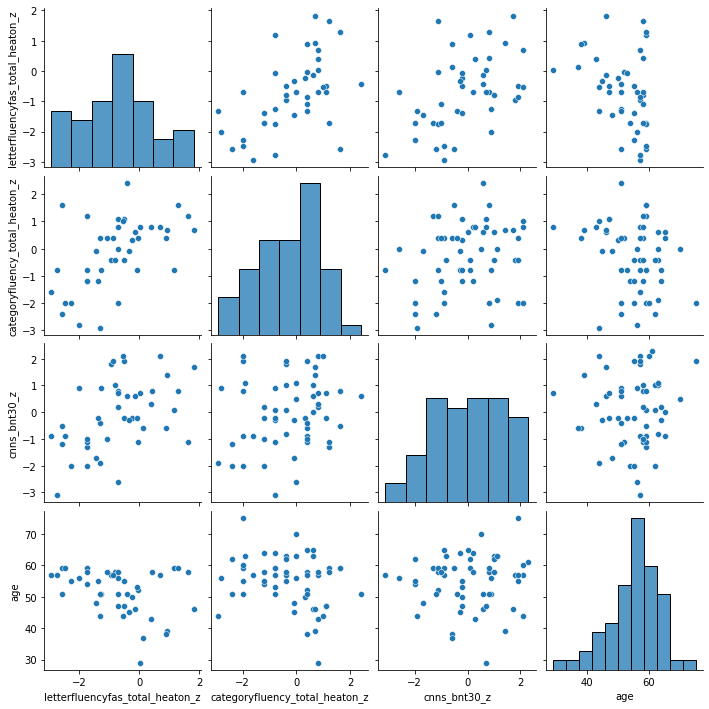

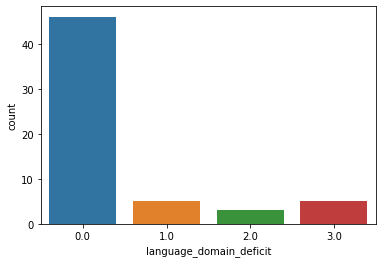

In [30]:
lang_domain = LanguageDomain.from_defaults(method = SHOW_DATA)
lang_domain.summarize_domain(map_neuro)

# Visuospatial Doamin

In [34]:
# export

from autoneuro.batteries import ClockDrawingBattery, ROCFBattery

class VisuoSpatialBattery(ABDomainBattery):
    
    section = 'VisuoSpatial Domain'
    prefix = 'visuospatial_domain' # visoconstruction
    domain_cols = ['clocksum', 
                   'rocf'
                  ]
    

class NewVisuoSpatialBattery(VisuoSpatialBattery):
    
    prefix_ops = CNNSConversionOp.multi_cnns('cnns_clock1_t',
                                             'cnns_clock2_t',
                                             'cnns_clocksum_t',
                                             'cnns_reyo_t', 
                                             'cnns_reytime_t')
    domain_cols = ['cnns_clocksum_z',
                   'cnns_reyo_z',]     
    

    


class VisuoSpatialDomain(AbstractDomain):
    
    @staticmethod
    def from_defaults(root_data = 'data/', method = 'new'):
        
        batteries = [ClockDrawingBattery.from_defaults(),
                     ROCFBattery.from_defaults()]
        
        if method == 'new':
            batteries.append(NewVisuoSpatialBattery.from_defaults())
        else:
            batteries.append(VisuoSpatialBattery.from_defaults())
            
        return VisuoSpatialDomain(batteries)

VisuoSpatialDomain
Batteries: ClockDrawingBattery, ROCFBattery, NewVisuoSpatialBattery
Composed of: cnns_clocksum_z, cnns_reyo_z
Example calculation:
Input: 
 clockcommand2:4.0
 clockcopy2:5.0
 cnns_clock1_t:42.0
 cnns_clock2_t:71.0
 cnns_clocksum_t:51.0
 cnns_reyo_t:64.0
 cnns_reytime_t:50.0
 rocf:32.0
 rocftime:240.0
Calculating: ['clocksum']
Used Equation: clockcommand2+clockcopy2 = 9.0 = clocksum 

Calculating: ['clocksum_plc']
Used Equation: clocksum = 9.0 = clocksum_plc 

Calculating: ['rocf_plc']
Used Equation: rocf = 32.0 = rocf_plc 

Calculating: ['cnns_clock1_z']
CNNS Scaling: Scaling t-score cnns_clock1_t = 42.0
CNNS Scaling: to z-scale cnns_clock1_z = -0.8 

Calculating: ['cnns_clock2_z']
CNNS Scaling: Scaling t-score cnns_clock2_t = 71.0
CNNS Scaling: to z-scale cnns_clock2_z = 2.1 

Calculating: ['cnns_clocksum_z']
CNNS Scaling: Scaling t-score cnns_clocksum_t = 51.0
CNNS Scaling: to z-scale cnns_clocksum_z = 0.1 

Calculating: ['cnns_reyo_z']
CNNS Scaling: Scaling t-scor

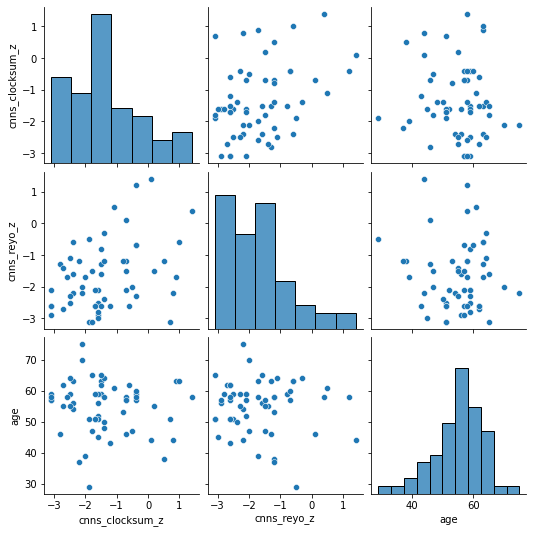

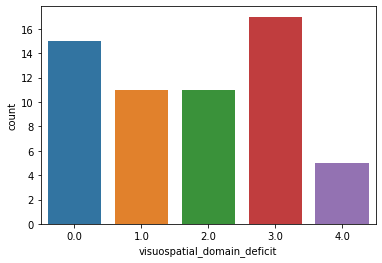

In [35]:
vs_domain = VisuoSpatialDomain.from_defaults(method = SHOW_DATA)
vs_domain.summarize_domain(map_neuro)

## Collection

Last we need a way to collect all of these domains together to manage of the interelated activities.

This can take care of things like:
 - Loading, merging, and holding multiple datasets.
 - Hold the `FieldMapper`.
 - Handle passing merged data to the domains.
 - Plotting things that involve multiple domains.

In [36]:
# export
# hide

from autoneuro.batteries import DemographicsBattery


class Collection(object):
    
    def __init__(self, mapper, domains, extra_batteries = None):
        
        self.mapper = mapper
        self.domains = dict((d.name, d) for d in domains)
        self.measured_data = None
        self.extra_batteries = extra_batteries if extra_batteries is not None else []
        self.extra_data = None
        
    @staticmethod
    def from_defaults(mapping_path = 'data/field_mappings_merged.xlsx', extra_post_convert = [], method = 'new'):
        
        mapper = FieldMapper.from_file('data/field_mappings_merged.xlsx',
                                      post_convert = [fix_dates, fix_study_ids]+extra_post_convert)
        domains = [VerbalMemoryDomain.from_defaults(method = method),
                   VisuospatialMemoryDomain.from_defaults(method = method), 
                   ProcessingSpeedDomain.from_defaults(method = method),
                   MotorDomain.from_defaults(method = method), 
                   ExecutiveFunctionDomain.from_defaults(method = method), 
                   AttentionDomain.from_defaults(method = method),
                   LanguageDomain.from_defaults(method = method)]
        
        extra_batteries = [DemographicsBattery.from_defaults()]
        
        return Collection(mapper, domains, extra_batteries=extra_batteries)
    
    @property
    def domain_z_scores(self):
        
        fields = []
        for _, domain in self.domains.items():
            fields.append(domain.domain_score_field)
        return self.scaled_data[fields]

    @property
    def domain_deficit_scores(self):
        fields = []
        for _, domain in self.domains.items():
            fields.append(domain.deficit_score_name)
        return self.scaled_data[fields]    
    
    
    def load_data(self, datasets, index_keys = ['study_id', 'date_of_visit']):
        """Load and merge multiple sources.
        Expects ('id_system', path) list as input.
        """
        
        self.measured_data = self.mapper.multi_merge('internal_field', datasets, index_keys = index_keys)
        return self

    
    def _scale_data(self, measured_data, as_multi_index = False,
                    extra_batteries = []):
        
        out = {}
        for key, domain in self.domains.items():
            out[key] = domain(measured_data)
            
        for bat in self.extra_batteries+extra_batteries:
            out[bat.__class__.__name__] = bat(measured_data)
        
        if as_multi_index:
            return pd.concat(out.values(), 
                             axis=1, 
                             keys=out.keys(), 
                             sort=False)
        else:
            mat = pd.concat(out.values(), 
                            axis=1,                              
                            sort=False)
            mat = mat.loc[:, ~mat.columns.duplicated()]
            return mat
    
    
    def scale_data(self, extra_batteries = []):
            
        self.scaled_data = self._scale_data(self.measured_data, 
                                            as_multi_index=False,
                                           extra_batteries = extra_batteries)        
        
        return self
    
    def to(self, path, id_system):
        
        
        if path.endswith('.xls') or path.endswith('.xlsx'):
            pass
            
        
        
    
    
    

In [37]:
cnac = Collection.from_defaults().load_data(paths).scale_data()
cnac.scaled_data.dropna(subset=req_fields).tail()

,,age,cnns_hdiscrim_t,cnns_hretain_t,cnns_hvlt4_t,cnns_hvlt_t,hvlt1intr,hvlt1pers,hvlt2pers,hvlt_delay,hvlt_false_pos,...,categoryfluency_total,categoryfluency_total_scaled,categoryfluency_total_heaton_z,bnt30_plc,cnns_swords_z,cnns_anwords_z,cnns_bnt30_z,language_domain_z,language_domain_deficit,race_desc
study_id,date_of_visit,,,,,,,,,,,,,,,,,,,,,
757,2021-01-12,48.0,23.0,47.0,45.0,42.0,1.0,0.0,0.0,6.0,7.0,...,19.0,10.0,-0.1,22.0,-0.6,0.5,-1.7,-1.082866,1.0,AA
759,2021-01-27,43.0,30.0,25.0,19.0,24.0,0.0,0.0,0.0,1.0,2.0,...,25.0,13.0,0.8,30.0,0.7,0.5,0.3,0.494643,0.0,white
761,2021-02-09,44.0,60.0,61.0,59.0,56.0,0.0,1.0,2.0,9.0,1.0,...,25.0,13.0,1.0,30.0,0.2,2.2,2.1,0.852778,0.0,AA
762,2021-03-03,58.0,22.0,32.0,30.0,57.0,0.0,0.0,0.0,1.0,4.0,...,15.0,8.0,-1.2,25.0,-1.5,-0.5,-1.0,-1.309657,1.0,AA
763,2021-03-04,65.0,22.0,36.0,33.0,34.0,3.0,0.0,0.0,5.0,4.0,...,23.0,12.0,0.6,29.0,-1.5,0.7,0.0,0.300000,0.0,white


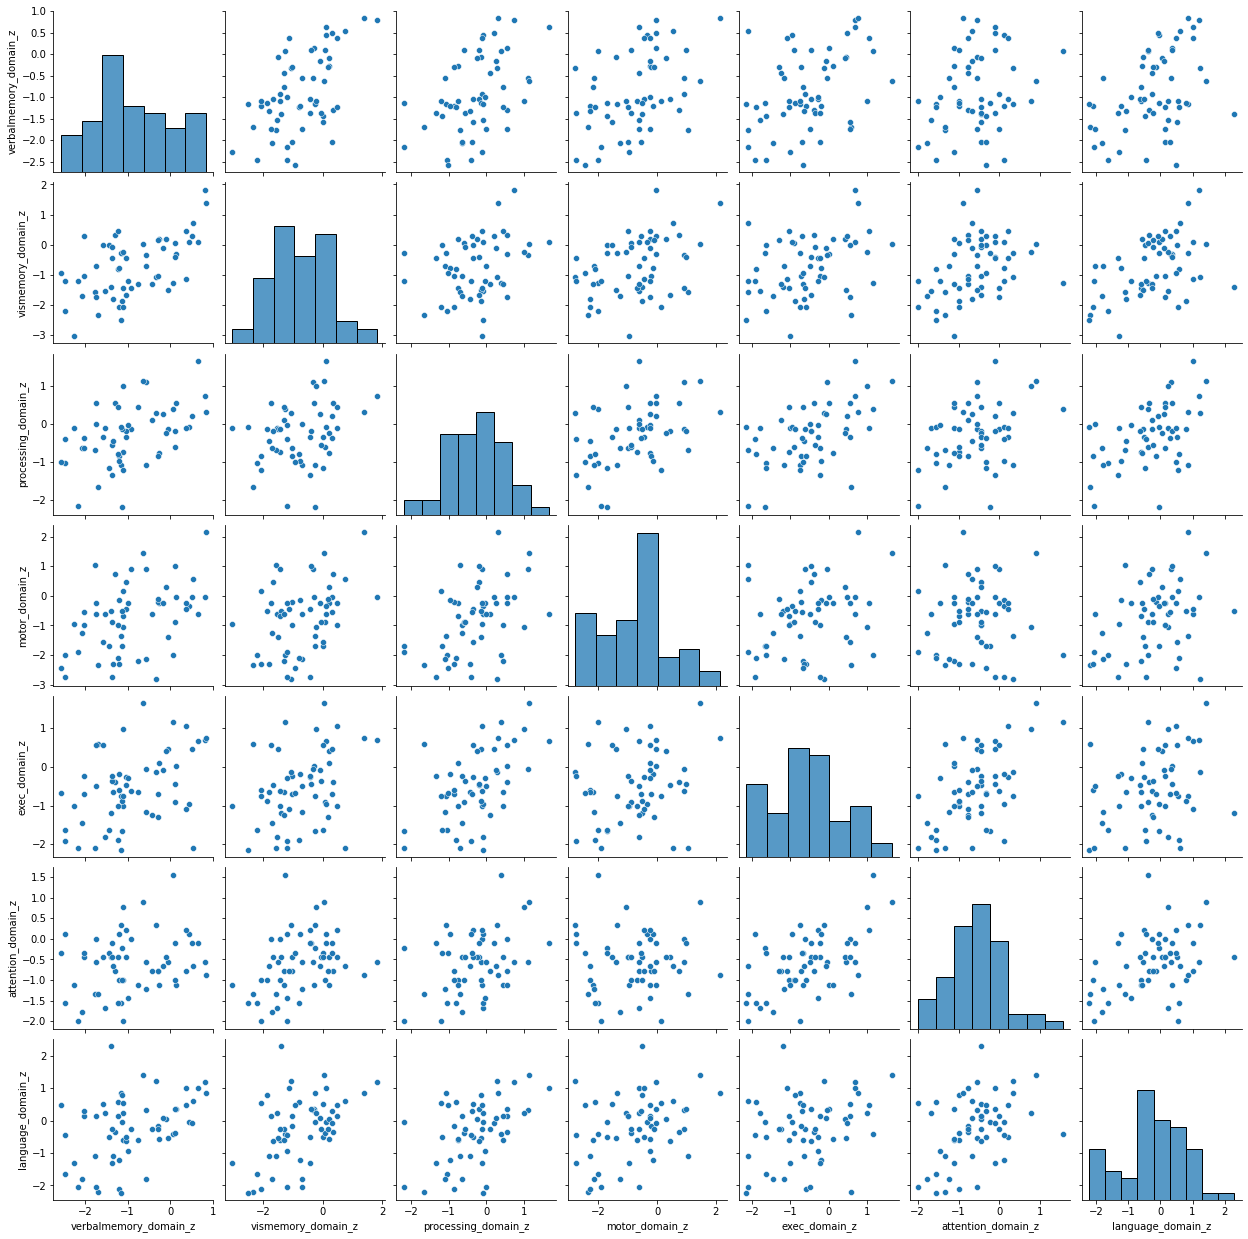

In [38]:
sbn.pairplot(data = cnac.domain_z_scores.dropna(how = 'all'))

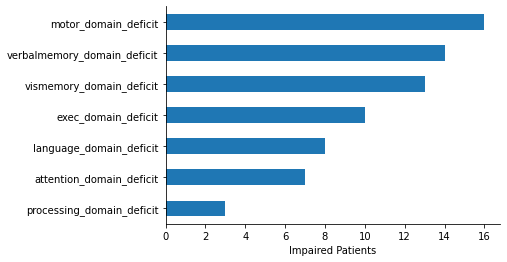

In [40]:
ax = (cnac.domain_deficit_scores.dropna(how = 'all')>1).sum().sort_values().plot(kind = 'barh')
ax.set_xlabel('Impaired Patients')
sbn.despine(ax=ax)

<AxesSubplot:xlabel='study_id-date_of_visit'>

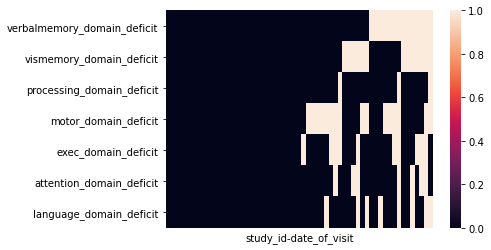

In [49]:
mask = cnac.domain_deficit_scores.dropna(how = 'all')>1
mask = mask.sort_values(by = list(mask.columns))
sbn.heatmap(mask.T, xticklabels=False)

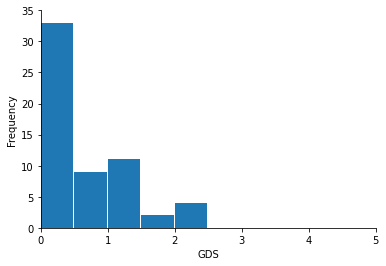

In [57]:
gds = cnac.domain_deficit_scores.dropna(how = 'all').mean(axis=1)
ax = gds.plot(kind = 'hist', bins=np.arange(0, 5.5, 0.5), width = 0.48)
ax.set_xlabel('GDS')
ax.set_ylim(0, 35)
ax.set_xlim(0, 5)
sbn.despine(ax=ax)

In [76]:
data_set = pd.concat([cnac.scaled_data], axis=1)
data_set.dropna(subset = req_fields).to_csv('DD_neuro_2021_04_27.csv')

In [74]:
output = cnac.mapper.convert(data_set, 'internal_field', 'dd_id')
output.to_csv('DD_neuro_2021_04_27.csv')